<a href="https://colab.research.google.com/github/anujsahani01/NeuralCodeBot/blob/main/Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install datasets
! pip install huggingface_hub
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.5 MB/s eta 0:00:00


In [56]:
from huggingface_hub import notebook_login
notebook_login()

In [57]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your

In [58]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
dataset = load_dataset("anujsahani01/PyTextMap" , use_auth_token = True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2072: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


In [59]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text_prompt', 'code_prompt'],
        num_rows: 15976
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'text_prompt', 'code_prompt'],
        num_rows: 1997
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text_prompt', 'code_prompt'],
        num_rows: 1997
    })
})

In [60]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder")
tokenizer.bos_token = tokenizer.eos_token

In [61]:
def tokenize(data):
  prompt = tokenizer(data['text_prompt'], return_length = True)
  inp_ids = []
  inp_len = []
  if prompt['length'][0] != 0:
    for length, ids in zip(prompt["length"], prompt["input_ids"]):
      inp_ids.append(ids)
      inp_len.append(length)
    code = tokenizer(data['code_prompt'], return_length = True)
    label = []
    label_len = []
    for length, lb in zip(code["length"], code["input_ids"]):
      label.append(lb)
      label_len.append(int(length))
  return {"input_ids": inp_ids,
          'labels' : label,
          'input_length' : inp_len,
          'code_length' : label_len}

In [62]:
tokenized_data = dataset.map(tokenize , batched = True, remove_columns = ['Unnamed: 0', 'code_prompt', 'text_prompt'])

In [63]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'input_length', 'code_length'],
        num_rows: 15976
    })
    validation: Dataset({
        features: ['input_ids', 'labels', 'input_length', 'code_length'],
        num_rows: 1997
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'input_length', 'code_length'],
        num_rows: 1997
    })
})

In [64]:
import statistics
import numpy as np
print('Minimum:', np.min(tokenized_data['train']['input_length']), 'Maximum: ' , np.max(tokenized_data['train']['input_length']), 'Mean: ', np.mean(tokenized_data['train']['input_length']), 'Mode:' , statistics.mode(tokenized_data['train']['input_length']))

Minimum: 38 Maximum:  11169 Mean:  701.6742613920882 Mode: 2241


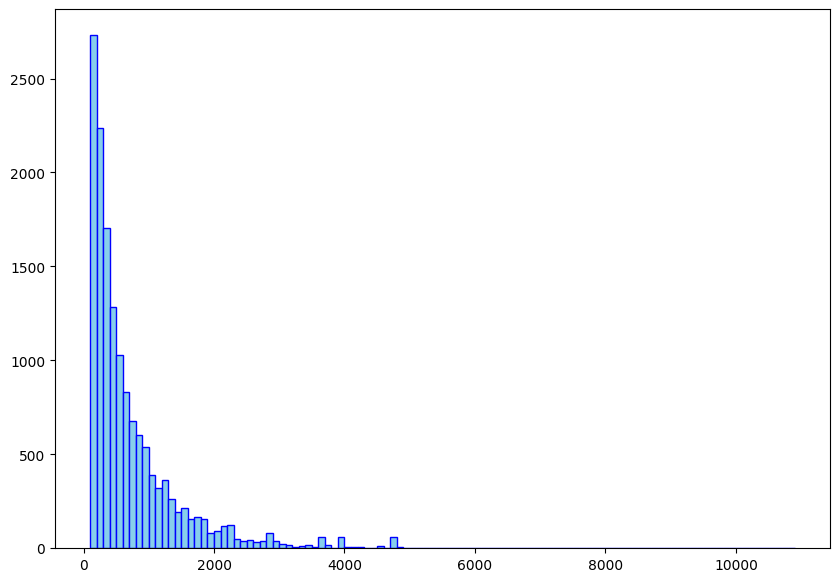

In [65]:
import matplotlib.pyplot as plt

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(tokenized_data['train']['input_length'], bins =[i for i in range(100, 11000, 100)], color = "skyblue", ec="blue")

# Show plot
plt.show()

In [66]:
import statistics
import numpy as np
print('Minimum:', np.min(tokenized_data['train']['code_length']), 'Maximum: ' , np.max(tokenized_data['train']['code_length']), 'Mean: ', np.mean(tokenized_data['train']['code_length']), 'Mode:' , statistics.mode(tokenized_data['train']['code_length']))

Minimum: 27 Maximum:  54525 Mean:  3246.2486229344017 Mode: 4590


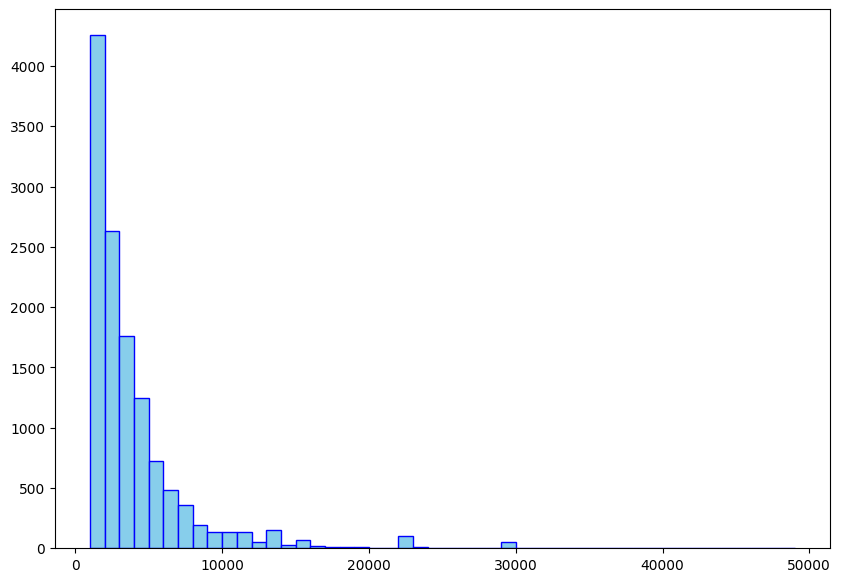

In [67]:
import matplotlib.pyplot as plt

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(tokenized_data['train']['code_length'], bins =[i for i in range(1000, 50000, 1000)], color = "skyblue", ec="blue")

# Show plot
plt.show()

In [68]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

all_tokens = []

text_tokens = np.concatenate(tokenized_data['train']['input_ids'])
code_tokens = np.concatenate(tokenized_data['train']['labels'])

all_tokens = np.concatenate([text_tokens, code_tokens])
# Count token frequencies
token_counter = Counter(all_tokens)

# Sort tokens by frequency in descending order
sorted_tokens = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)

# Extract token and frequency for plotting
tokens, frequencies = zip(*sorted_tokens)

In [81]:
words = []
for i in range(100):
  words.append(tokenizer.decode(tokens[i]))

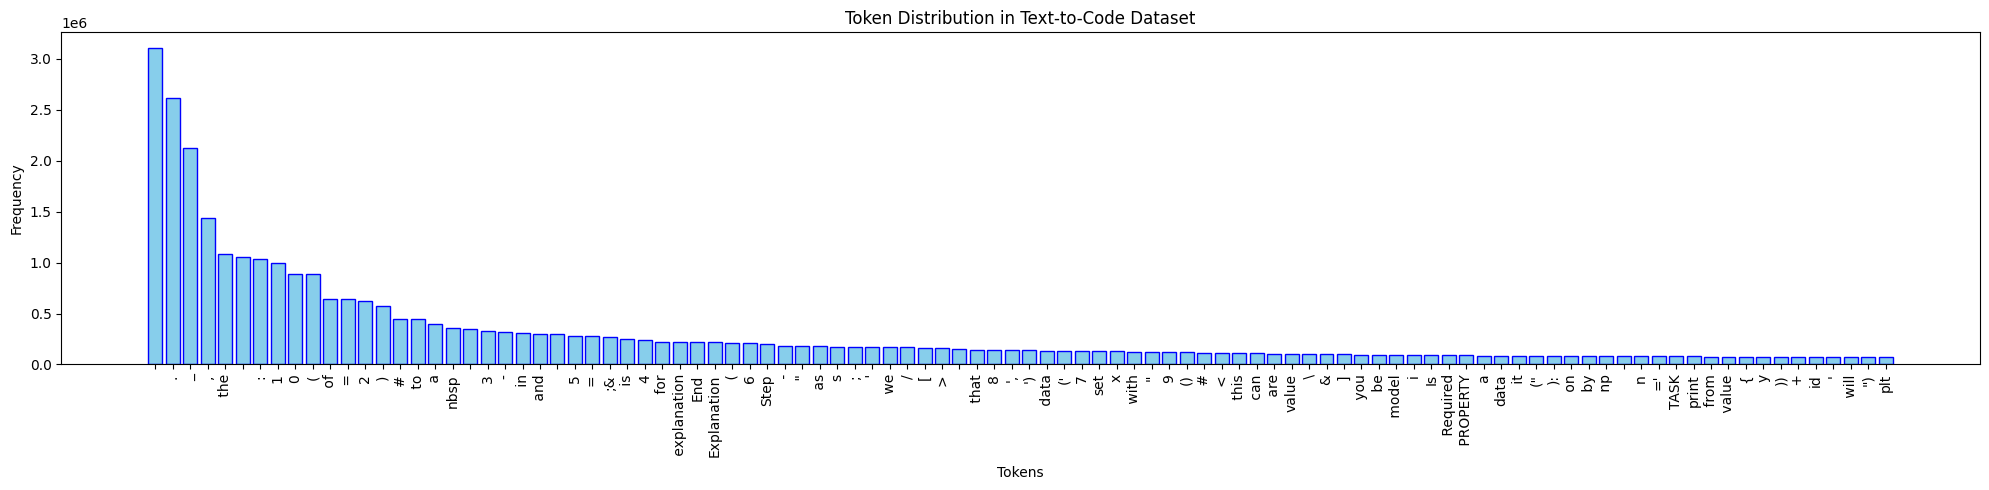

In [83]:
# Plot token distribution
plt.figure(figsize=(20, 5))
plt.bar(range(len(tokens[:100])), frequencies[:100], tick_label=words, color = "skyblue", ec="blue")
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.title('Token Distribution in Text-to-Code Dataset')
plt.tight_layout()
plt.show()